# Display current agent performance

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
gym.logger.set_level(40)
import matplotlib.pyplot as plt

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Watch agents play an episode of each game

Let's define a list of all the games for which we have a trained agent ready

In [2]:
game_name = ['CartPole', 'MountainCar', 'LunarLander', 'Acrobot']
version = ['v0', 'v0', 'v2', 'v1']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

Now for each game, load the trained model and run one episode. I'm adding a limit for the maximal number of steps as some of the games can have very long episodes

In [3]:
for i in range(len(game_name)):
    
    ep_reward = []
    env = gym.make(game_name[i] + '-' + version[i]) # Create an instance of the game environment
    env._max_episode_steps = 1000 # Limit maximal number of steps per episode

    with tf.Session() as sess:

        '''Load model'''
        saver = tf.train.import_meta_graph("models/" + game_name[i] + "/model.ckpt.meta") # import saved graph
        saver.restore(sess, "models/" + game_name[i] + "/model.ckpt") # load model parameters
        graph = tf.get_default_graph() # create a graph instance containing all the tensors
        action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
        input_ = graph.get_tensor_by_name("input:0") # get the input tensor

        '''Play an episode according to the model'''
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            env.render() # Render game
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(len(apd)), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward) # Append step reward to episode rewards list
            t = t+1
            if done:
                print("Game ended after {} steps".format(t+1))
                print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
                break
    env.close()
    tf.reset_default_graph() # Reset graph for allowing next model to be loaded

INFO:tensorflow:Restoring parameters from models/CartPole/model.ckpt
Game ended after 1001 steps
Total reward earned in this episode: 1000.00
INFO:tensorflow:Restoring parameters from models/MountainCar/model.ckpt
Game ended after 931 steps
Total reward earned in this episode: -930.00
INFO:tensorflow:Restoring parameters from models/LunarLander/model.ckpt
Game ended after 133 steps
Total reward earned in this episode: 82.10
INFO:tensorflow:Restoring parameters from models/Acrobot/model.ckpt
Game ended after 131 steps
Total reward earned in this episode: -129.00


## Evaluate agents performance

Game solving thresholds (from [OpenAI wiki](https://github.com/openai/gym/wiki/Leaderboard)):

* CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials
* MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials
* LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials
* Acrobot-v1 is an unsolved environment, which means it does not have a specified reward threshold at which it's considered solved


In order to get a better sense of the agets performance we need more statisics. We'll let each agent paly 100 episodes, compute the mean and std, and plot a histogram of the results:

Mean episode reward in CartPole is: 1000 ± 0
Mean episode reward in MountainCar is: -647 ± 179
Mean episode reward in LunarLander is: 215 ± 100
Mean episode reward in Acrobot is: -147 ± 33


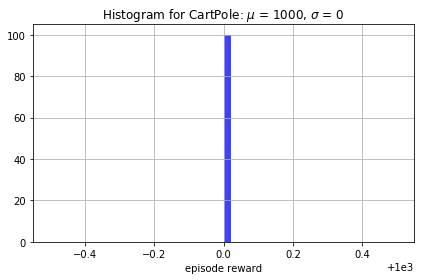

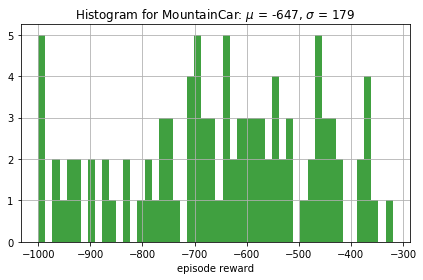

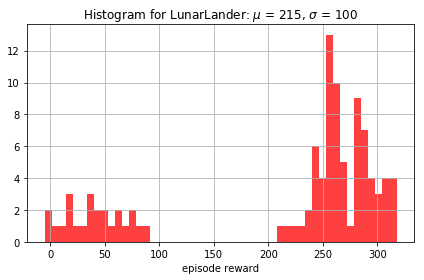

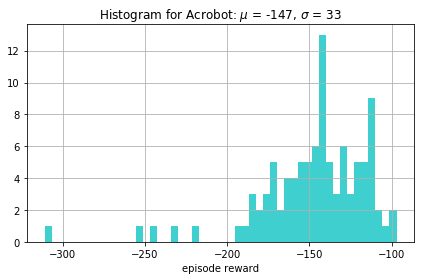

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR) # Hide loading models INFO messages
for i in range(len(game_name)):
    sess = tf.Session()
    
    '''Define environment'''
    env = gym.make(game_name[i] + '-' + version[i]) # Create an instance of the game environment
    env._max_episode_steps = 1000 # Limit maximal number of steps per episode
    
    '''Load model'''
    saver = tf.train.import_meta_graph("models/" + game_name[i] + "/model.ckpt.meta") # import saved graph
    saver.restore(sess, "models/" + game_name[i] + "/model.ckpt") # load model parameters
    graph = tf.get_default_graph() # create a graph instance containing all the tensors
    action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
    input_ = graph.get_tensor_by_name("input:0") # get the input tensor
    
    total_reward = []
    for j in range(100):
        ep_reward = []
        '''Play an episode according to the model'''
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(len(apd)), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward) # Append step reward to episode rewards list
            t = t+1
            if done:
                total_reward.append(np.sum(ep_reward)) # Append the total reward in this episode 
                break
    sess.close()
    mean_reward = int(np.mean(total_reward)) # Compute the mean reward per episode 
    std_reward = int(np.std(total_reward)) # Compute std of the reward over episodes
    print("Mean episode reward in " + game_name[i] + " is: {:d} ".format(mean_reward) 
           + u"\u00B1" + " {:d}".format(std_reward))
    
    '''Plot historagms'''
    plt.figure()
    plt.hist(total_reward, 50, facecolor = colors[i] ,alpha = 0.75)
    plt.title("Histogram for " + game_name[i] + ": " + r"$\mu$ =" + " {:d}, ".format(mean_reward) 
               + r"$\sigma$ =" + " {:d}".format(std_reward))
    plt.xlabel("episode reward")
    plt.grid(True)
    plt.tight_layout()
    
    tf.reset_default_graph() # Reset graph for allowing next model to be loaded

## Action probability maps

Let's try to gain some understanding of the policies our agents have learned. one way to do so is by ploting an action map over observation space, showing the probability of taking some action in each posion in observation space.

### Mountain Car

Mountain car has 3 discrete actions (left, right and idle) and a 2D observation space of position and velocity.

We can try to visualize the learned policy by ploting a 2D map of the probability to take some action in each point in the observation space, first we have to calculate the PDF based on our model for every point and then save the probability for each action in its own matrix:

In [5]:
pos = np.linspace(-1.2, 0.6, 50) # position vector
velocity = np.linspace(-0.07, 0.07, 50) # velocity vector

with tf.Session() as sess:
    '''Load model'''
    saver = tf.train.import_meta_graph("models/" + game_name[1] + "/model.ckpt.meta") # import saved graph
    saver.restore(sess, "models/" + game_name[1] + "/model.ckpt") # load model parameters
    graph = tf.get_default_graph() # create a graph instance containing all the tensors
    action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
    input_ = graph.get_tensor_by_name("input:0") # get the input tensor

    '''Create action map'''
    left_action_map = np.zeros((len(velocity),len(pos)))
    right_action_map = np.zeros_like(left_action_map)
    idle_action_map = np.zeros_like(left_action_map)
    for i in range(len(velocity)):
        for j in range(len(pos)):

            obs = np.array([pos[j], velocity[i]]) # Create observation for this pixel
            # Use model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            left_action_map[i,j] = apd[0] # save the probability to move left to the map
            idle_action_map[i,j] = apd[1] # save the probability to move idle to the map
            right_action_map[i,j] = apd[2] # save the probability to move right to the map

tf.reset_default_graph() # Reset graph for allowing next model to be loaded

Now we can visualize the policy, we plot the action probability maps for each action and investigate the policy:

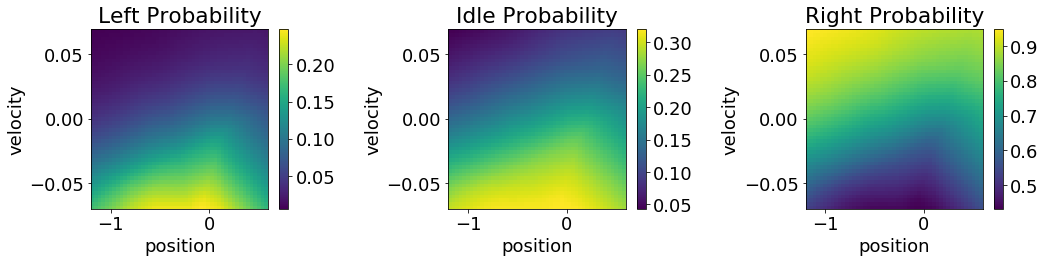

In [6]:
plt.rcParams.update({'font.size': 18})
'''Plot action map'''
plt.figure(figsize = [15, 4])
plt.subplot(1,3,1)
plt.pcolormesh(pos, velocity, left_action_map)
plt.colorbar()
plt.title("Left Probability")
plt.xlabel("position")
plt.ylabel("velocity")

plt.subplot(1,3,2)
plt.pcolormesh(pos, velocity, idle_action_map)
plt.colorbar()
plt.title("Idle Probability")
plt.xlabel("position")
plt.ylabel("velocity")

plt.subplot(1,3,3)
plt.pcolormesh(pos, velocity, right_action_map)
plt.colorbar()
plt.title("Right Probability")
plt.xlabel("position")
plt.ylabel("velocity")

plt.tight_layout()

### Cart Pole

Cart Pole has two discrete actions (left or right) and a 4D observation space (position, velocity, pole angle, pole velocity at the tip). We can only plot an action map over a 2D projection of the observation space, I have more intuition for (velocity, pole velocity at the tip) sub space so let's start by setting position and angle to zero and scan the other two:

In [7]:
v = np.linspace(-5, 5, 50) # velocity vector
pv = np.linspace(-5, 5, 50) # pole velocity vector

with tf.Session() as sess:
    '''Load model'''
    saver = tf.train.import_meta_graph("models/" + game_name[0] + "/model.ckpt.meta") # import saved graph
    saver.restore(sess, "models/" + game_name[0] + "/model.ckpt") # load model parameters
    graph = tf.get_default_graph() # create a graph instance containing all the tensors
    action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
    input_ = graph.get_tensor_by_name("input:0") # get the input tensor

    '''Create action map'''
    vpv_action_map = np.zeros((len(pv),len(v)))
    for i in range(len(pv)):
        for j in range(len(v)):

            obs = np.array([0, v[j], 0, pv[i]]) # Create observation for this pixel
            # Use model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            vpv_action_map[i,j] = apd[0] # save the probability to move left to the map

tf.reset_default_graph() # Reset graph for allowing next model to be loaded

Text(0,0.5,'pole velocity')

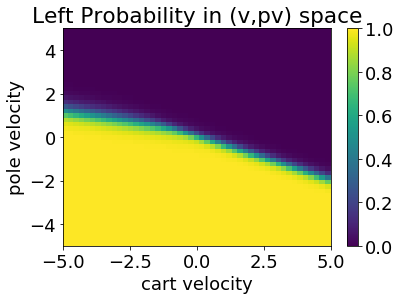

In [8]:
plt.rcParams.update({'font.size': 18})
'''Plot action map'''
plt.figure(figsize = [6, 4])
plt.pcolormesh(v, pv, vpv_action_map)
plt.colorbar()
plt.title("Left Probability in (v,pv) space")
plt.xlabel("cart velocity")
plt.ylabel("pole velocity")